In [1]:
library(tidyverse)
library(ggplot2)
library(patchwork)
source("helper.R")
library(scales)

-- Attaching packages --------------------------------------- tidyverse 1.3.1 --

v ggplot2 3.3.3     v purrr   0.3.4
v tibble  3.1.2     v dplyr   1.0.6
v tidyr   1.1.3     v stringr 1.4.0
v readr   1.4.0     v forcats 0.5.1

-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()


Attaching package: 'scales'


The following object is masked from 'package:purrr':

    discard


The following object is masked from 'package:readr':

    col_factor




In [2]:
win_size = 1000000
chrom= "chr12"
prop_acc=0.4
data_path="../../output/greatapes-diversity-data/"
outpath="../../output/final_figs/"
f_prefix="long-cor"
dir.create(outpath, recursive=T)

Warning message in dir.create(outpath, recursive = T):
"'../../output/final_figs' already exists"


In [4]:
neutral_cov_path="../../output/joined_stats/sup-rand-id_8MF0I020MWGI6N41PH_rep_0_sample-size_10_joinedcovs.tsv"

## Figure 3

In [5]:
rds_path = paste0(data_path,chrom,"/",f_prefix,"_win-size_",as.integer(win_size),"_merged-mask_True_state_all_curr_all_prop-acc_",prop_acc, ".rds")


In [6]:
df = readRDS(rds_path)
# resorting the spp combos -- will be needed to join with the neutral cov
df$combo1 = apply(df, 1, function(x) paste(x["spp1_1"], x["spp2_1"], sep="_"))
df$combo2 = apply(df, 1, function(x) paste(x["spp1_2"], x["spp2_2"], sep="_"))
df[,c("combo1","combo2")] = t(apply(df,1, function(x) sort(unlist(x[c("combo1", "combo2")]))))

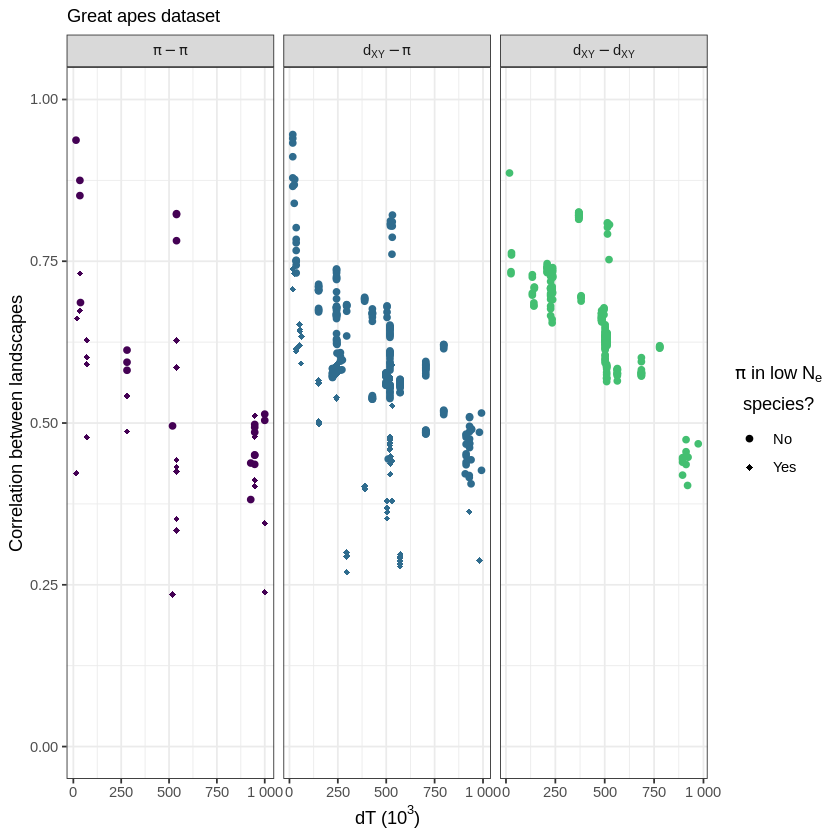

In [7]:
corr_dt_panel = function(df,subt="", x_colname="dt") {
    statcombolabs = c(`dxy_dxy`="d[XY]-d[XY]", `dxy_pi`="d[XY]-pi", `pi_pi`="pi-pi")
    lownelabs = c(`TRUE`="Yes", `False`="No")
    p_dt = ggplot(df[df$has_shared == FALSE,], aes_string(y="value", x=x_colname, label="stat_combo1", label2="stat_combo2", shape="lowne", col="statcombo")) + 
        geom_point() +
        scale_shape_manual(values=c(19, 18), labels=c("No", "Yes")) +
        scale_x_continuous(labels = label_number(scale = 1e-3)) +
        scale_color_viridis_d(direction=-1, end=0.7) +
        facet_grid(.~factor(statcombo, levels=c("pi_pi", "dxy_pi", "dxy_dxy")), scales="free", labeller=as_labeller(statcombolabs, default=label_parsed)) +
        labs(x=bquote("dT ("*10^3*")"), y="Correlation between landscapes", shape=bquote(atop(pi*" in low "*N[e], "species?")),
            subtitle=subt) +
        ylim(0,1) +
        guides(shape = guide_legend(title.position="top"), color=FALSE)+
        my_theme
    return(p_dt)
}
corr_dt_panel(df, subt="Great apes dataset")
ggsave(filename=paste0(outpath,"cor-pidxy-dT_data.pdf"), width = 6.5, height = 3.0, units = "in", dpi=300)

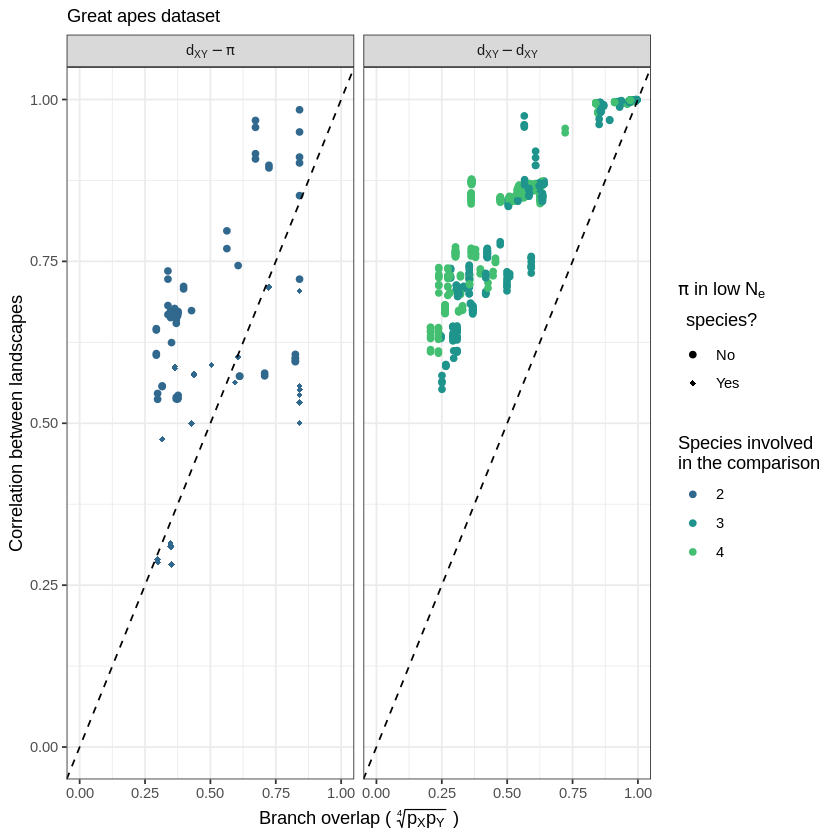

In [66]:
corr_panel = function(df,subt="", x_colname="sqsqpxpy", x_name=bquote("Branch overlap ("~sqrt(p[X]*p[Y],4)~")"), has_shared=TRUE) {
    #df$num_spp = as.character(df$num_spp)
    p_bo = ggplot(df[df$has_shared == has_shared,], aes(y=value, x=get(x_colname), label=stat_combo1, label2=stat_combo2, shape=lowne, col=factor(num_spp))) + 
        geom_point() +
        scale_shape_manual(values=c(19, 18), labels=c("No", "Yes")) +
        scale_color_viridis_d(direction=1,begin=1/3, end=0.7) +
        facet_grid(.~factor(statcombo, levels=c("pi_pi", "dxy_pi", "dxy_dxy")), scales="free", labeller=as_labeller(statcombolabs, default=label_parsed)) +
        labs(x=x_name, y="Correlation between landscapes", shape=bquote(atop(pi*" in low "*N[e], "species?")), 
             col="Species involved\nin the comparison", subtitle=subt) +
        geom_abline(intercept = 0, slope = 1, linetype = "dashed") +
        xlim(0.0,1.0) +
        ylim(0.0,1.0)+
        guides(colour = guide_legend(title.position="top"), shape = guide_legend(title.position="top")) +
        my_theme
    return(p_bo)
}
corr_bo_panel(df, subt="Great apes dataset")
ggsave(filename=paste0(outpath,"cor-pidxy-branchoverlap_data.pdf"), width = 6.5, height = 3.0, units = "in", dpi=300)

In [54]:
# reading in neutral sim covariances
neutral_covs = read.table(neutral_cov_path, header=TRUE)
neutral_covs = neutral_covs %>%
  mutate(across(spp1_1:spp2_2, ~sub("gorila", "gorilla", .)))
neutral_covs[,c("spp1_1","spp2_1")] = t(apply(neutral_covs,1, function(x) sort(x[c("spp1_1", "spp2_1")])))
neutral_covs[,c("spp1_2","spp2_2")] = t(apply(neutral_covs,1, function(x) sort(x[c("spp1_2", "spp2_2")])))
neutral_covs$combo1 = apply(neutral_covs, 1, function(x) paste(x["spp1_1"], x["spp2_1"], sep="_"))
neutral_covs$combo2 = apply(neutral_covs, 1, function(x) paste(x["spp1_2"], x["spp2_2"], sep="_"))
neutral_covs[,c("combo1","combo2")] = t(apply(neutral_covs,1, function(x) sort(x[c("combo1", "combo2")])))
#neutral_covs

neutral_covs$corr = NA

for (i in 1:nrow(neutral_covs)) {
    # corr is cov/sqrt(var1*var2)
    # sd = cov(a,a)
    row_var_1 = (neutral_covs[,"combo1"] == neutral_covs[i,"combo1"]) & 
        (neutral_covs[,"combo2"] == neutral_covs[i,"combo1"]) 
    row_var_2 = (neutral_covs[,"combo1"] == neutral_covs[i,"combo2"]) & 
        (neutral_covs[,"combo2"] == neutral_covs[i,"combo2"]) 
    norm = sqrt(neutral_covs[row_var_1,"cov"])*sqrt(neutral_covs[row_var_2,"cov"])
    #print(norm)
    neutral_covs[i,"corr"] = neutral_covs[i,"cov"] / norm
}

In [55]:
df = left_join(x=df, y=neutral_covs[,c("corr","combo1","combo2")])

Joining, by = c("combo1", "combo2")



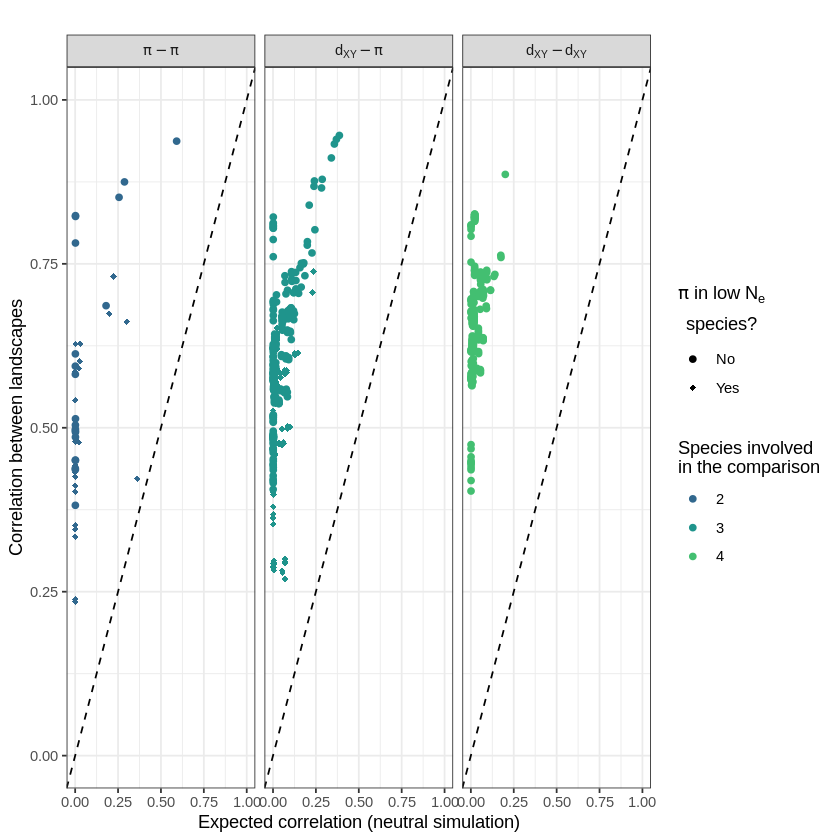

In [68]:
corr_panel(df,subt="", x_colname="corr", x_name="Expected correlation (neutral simulation)", has_shared=FALSE)
ggsave(filename=paste0(outpath,"cor-pidxy-corrneut-nooverlap_data.pdf"), width = 6.5, height = 3.0, units = "in", dpi=300)

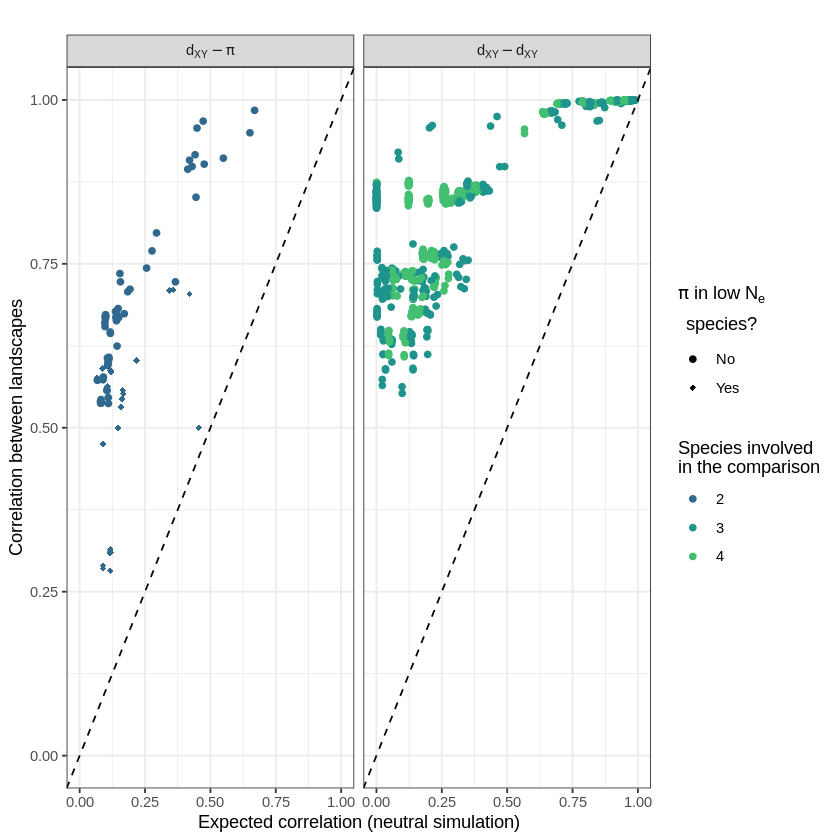

In [69]:
corr_panel(df,subt="", x_colname="corr", x_name="Expected correlation (neutral simulation)", has_shared=TRUE)

ggsave(filename=paste0(outpath,"cor-pidxy-corrneut-overlap_data.pdf"), width = 6.5, height = 3.0, units = "in", dpi=300)

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



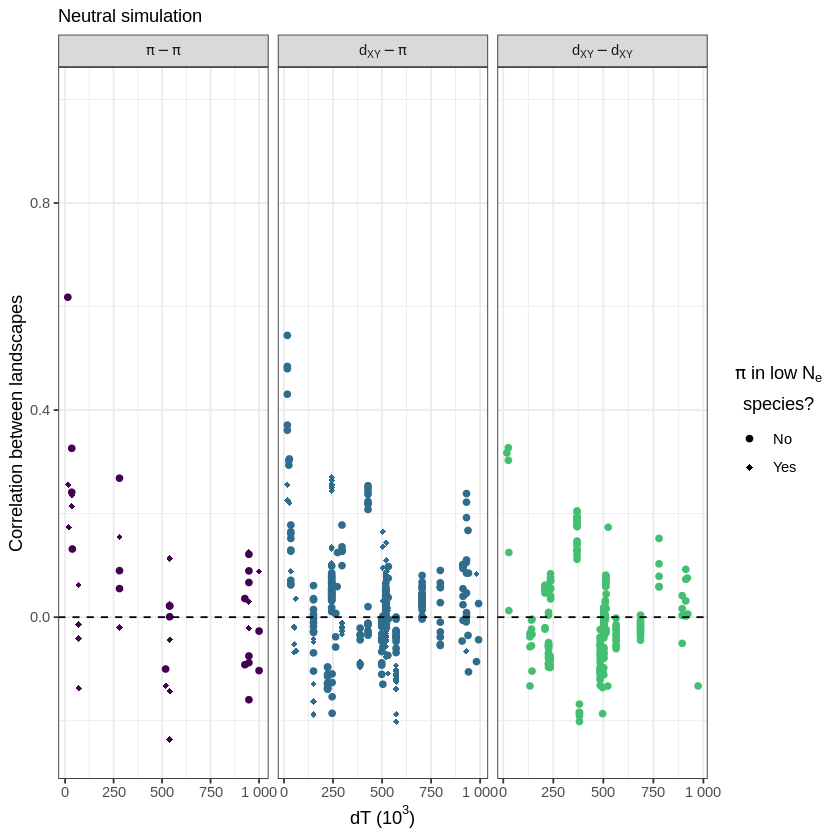

In [16]:
rds_path_neutral = "../../output/sims_results/sup-rand-id_8MF0I020MWGI6N41PH_rep_0_win-size_1000000_sample-size_10/long-cor_sup-rand-id_8MF0I020MWGI6N41PH_rep_0_win-size_1000000_sample-size_10_prop-acc_0.4.rds"
neudf = readRDS(rds_path_neutral)
corr_dt_panel(neudf, subt="Neutral simulation")+ylim(-0.25,1)+geom_abline(intercept = 0, slope = 0, linetype = "dashed") +
ggsave(filename=paste0(outpath,"cor-pidxy-dT_neutral.pdf"), width = 6.5, height = 3.0, units = "in", dpi=300)